In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [84]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mpl
import os
import scipy.stats as si
import matplotlib.pyplot as plt

In [196]:
sol_data = yf.download("SOL-USD", start="2020-12-01", end="2022-12-01")

[*********************100%***********************]  1 of 1 completed


In [197]:
sol_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-01,1.968321,2.130341,1.932264,1.976308,1.976308,12847022
2020-12-02,1.977266,2.187437,1.956700,2.115401,2.115401,15849828
2020-12-03,2.117117,2.221310,2.085030,2.100371,2.100371,18106122
2020-12-04,2.098602,2.112071,1.847345,1.855953,1.855953,9019864
2020-12-05,1.855968,1.980722,1.825494,1.978774,1.978774,7750781


In [198]:
sol_data['Adj Close'].head()

Date
2020-12-01    1.976308
2020-12-02    2.115401
2020-12-03    2.100371
2020-12-04    1.855953
2020-12-05    1.978774
Name: Adj Close, dtype: float64

In [199]:
adj_close =  sol_data['Adj Close']
adj_close.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 730 entries, 2020-12-01 to 2022-11-30
Series name: Adj Close
Non-Null Count  Dtype  
--------------  -----  
730 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


In [200]:
adj_close.head()

Date
2020-12-01    1.976308
2020-12-02    2.115401
2020-12-03    2.100371
2020-12-04    1.855953
2020-12-05    1.978774
Name: Adj Close, dtype: float64

In [201]:
adj_close.tail()

Date
2022-11-26    14.159194
2022-11-27    14.115767
2022-11-28    13.404518
2022-11-29    13.369734
2022-11-30    14.115445
Name: Adj Close, dtype: float64

array([<AxesSubplot:xlabel='Date'>], dtype=object)

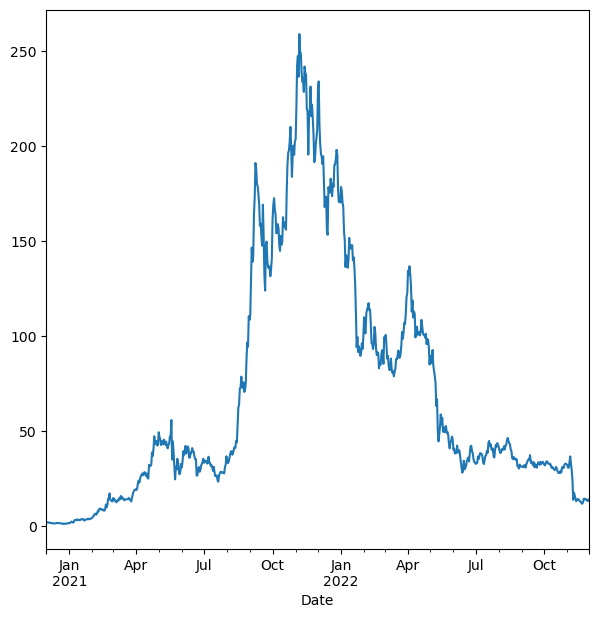

In [233]:
adj_close.plot(figsize=(7, 7), subplots=True, kind="line")
#subplot = true each column has its own subplot

In [240]:
### Spot Price ###
S0 = adj_close[-1]             # spot stock price
print('The spot price is $', round(S0,2), '.')

The spot price is $ 14.12 .


In [321]:
data3 = adj_close[-91:-1]
log_return = np.log(data3/ data3.shift(1))
log_return.head().round(4)
Log_ret_mean = np.mean(log_return)
print('The log-return of Solana from the 3month-annlysied period is', (Log_ret_mean))
### Annualized Volatility###
#log_return = np.log(adj_close / adj_close.shift(1))
sig = np.sqrt(365) * log_return.std()
print(sig)#prints the value of sigma
print('The annualised volatility is', round(sig*100,2), '%')

The log-return of Solana from the 3month-annlysied period is -0.009659666424067105
1.549506265224169
The annualised volatility is 154.95 %


In [322]:
### Strike Price ###
K = S0 + 1 
#Strike price higher than spot price for put option, giving the option 'intrinsic valvue' and puttin it In-The-Money
print(f"The strike price is $ {round(K,2)}.")

The strike price is $ 15.12.


In [323]:
### MATURITY ###
T  = 2/52 #two weeks
print(f"The time to maturity is {round(T,2)} years.")

The time to maturity is 0.04 years.


In [324]:
### Risk Free Rate ###
r = 0.03 #Source - Bloomberg
print(f"The risk free rate of return {round(r*100,2)} %.")
print("Source - Bloomberg")

The risk free rate of return 3.0 %.
Source - Bloomberg


In [342]:
### Number of periods or number of time steps ###
N = 3 

In [343]:
### PUT option ###
payoff = "put" 

In [344]:
### BINOMIAL PRICE TREE ###

In [346]:
dT = float(T) / N                             # Delta t
u = np.exp(sig * np.sqrt(dT))                 # up factor
d = 1.0 / u                                  # down factor 
print(f"Delta is {dT}, up-factor is {u} and down-factor is {d}")

Delta is 0.012820512820512822, up-factor is 1.191778865410328 and down-factor is 0.8390818372632419


In [347]:
S = np.zeros((N + 1, N + 1)) #Current Price
S[0, 0] = S0
z = 1
for t in range(1, N + 1):
    for i in range(z):
        S[i, t] = S[i, t-1] * u
        S[i+1, t] = S[i, t-1] * d
    z += 1
print(S)

[[14.11544514 16.82248919 20.04868708 23.89360154]
 [ 0.         11.84401364 14.11544514 16.82248919]
 [ 0.          0.          9.93809673 11.84401364]
 [ 0.          0.          0.          8.33887646]]


In [348]:
a = np.exp(r * dT)    # risk free compound return
p = (a - d)/ (u - d)  # risk neutral up probability
q = 1.0 - p           # risk neutral down probability
print(f"risk free compound return = {a}")
print(f"risk neutral up probability = {p}")
print(f"risk neutral down probability = {p}")

risk free compound return = 1.000384689358596
risk neutral up probability = 0.45734111495854585
risk neutral down probability = 0.45734111495854585


### OPTION VALUE AT EACH FINAL NODE

In [349]:
S_T = S[:,-1]
V = np.zeros((N + 1, N + 1))
if payoff =="call":
    V[:,-1] = np.maximum(S_T-K, 0.0)
elif payoff =="put":
    V[:,-1] = np.maximum(K-S_T, 0.0)
print(f"{payoff} option values at final node are\n {V}")

put option values at final node are
 [[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         3.2714315 ]
 [0.         0.         0.         6.77656868]]


### OPTION VALUE AT Earlier NODE

In [350]:
# for European Option
for j in range(N-1, -1, -1):
    for i in range(j+1):
        V[i,j] = np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1])
print('The option values at earlier nodes ', '\n', (V))

The option values at earlier nodes  
 [[2.4018943  0.96262602 0.         0.        ]
 [0.         3.61658102 1.7745887  0.        ]
 [0.         0.         5.1715359  3.2714315 ]
 [0.         0.         0.         6.77656868]]


In [351]:
print('European ' + payoff, str( V[0,0]))

European put 2.4018942958952465


### European option with Black_scholes Model


In [352]:
def euro_option_bs(S, K, T, r, vol, payoff):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: risk free rate
    #vol: volatility of underlying asset
    #payoff: call or put
    
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        option_value = S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        option_value = - S * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

In [353]:
print(f"The European put option price is {euro_option_bs(S0, K, T, r, sig, payoff)}")

The European put option price is 2.2980209047877027


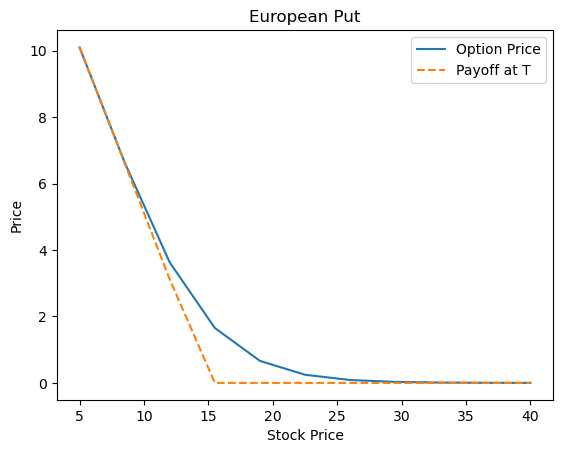

In [354]:
S = np.linspace(5,40,11)
cp = np.zeros((len(S),1))
for i in range(len(S)):
    cp[i] = euro_option_bs(S[i], K, T, r, sig, payoff)

fig = plt.figure()
plt.plot(S, cp, '-')
plt.plot(S, np.maximum(K-S,0), '--')
plt.xlabel('Stock Price')
plt.ylabel('Price')
plt.title('European Put')
plt.legend(['Option Price','Payoff at T'])

### MONTE CARLO SIMULATION 

In [355]:
def mcs_simulation_np(a):
    M = a #where a is the number of simulatios that need to be run
    dt = T / M 
    S = np.zeros((M + 1, M))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sig ** 2 / 2) * dt + sig * np.sqrt(dt) * rn[t]) 
    return S

[[14.11544514 14.08707621 14.48551705 ... 10.91323817 10.70350021
  10.6601672 ]
 [14.11544514 14.35307863 14.54775746 ... 13.26628754 13.2735737
  13.41157818]
 [14.11544514 14.21335795 14.07083556 ... 15.57612046 15.59745162
  15.6313033 ]
 ...
 [14.11544514 14.16207954 14.17071835 ... 17.2916642  17.26768923
  17.1410517 ]
 [14.11544514 14.23580493 14.19166316 ... 10.44104255 10.48056083
  10.58781243]
 [14.11544514 14.50090404 14.46598953 ... 14.48844522 14.57121206
  14.55583034]]


Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-preiod values')

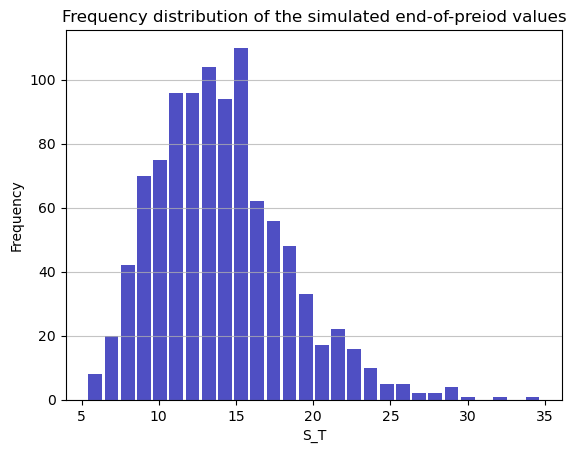

In [356]:
Sm = np.transpose(mcs_simulation_np(1000))
print(Sm)
n, bins, patches = plt.hist(x=Sm[:,-1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('S_T')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-preiod values')

In [357]:
put = np.mean(np.maximum(K - Sm[:,-1],0))
print('European put', str(put))

European put 2.268105286341529


## GREEKS

### Delta

In [358]:
def delta(S, K, T, r, q, sig, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * sig ** 2) * T) / (sig * np.sqrt(T))
    if payoff == "call":
        delta = np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0)
    elif payoff == "put":
        delta =  - np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0)
    
    return delta

In [359]:
print(f"The delta is {delta(S0, K, T, r, 0, sig, payoff)}.")

The delta is -0.5277058330528669.


[ 5.   8.5 12.  15.5 19.  22.5 26.  29.5 33.  36.5 40. ]


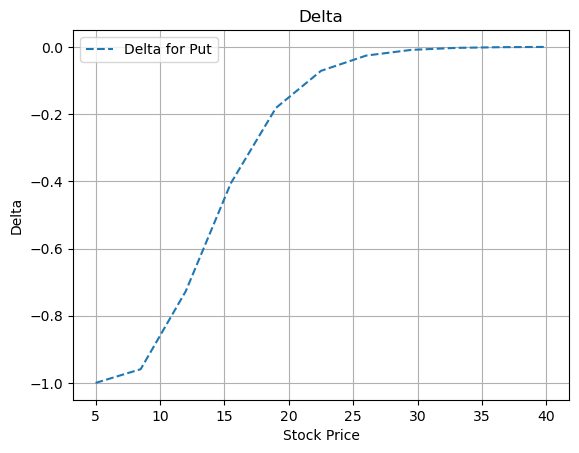

In [360]:
S = np.linspace(5,40,11)
print(S)
Delta_Put = np.zeros((len(S),1))
for i in range(len(S)):
    Delta_Put [i] = delta(S[i], K, T, r, 0, sig, payoff)
    
fig = plt.figure()
plt.plot(S, Delta_Put, '--')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Delta')
plt.title('Delta')
plt.legend(['Delta for Put'])

## Vega

In [361]:
def vega(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    vega = S * np.sqrt(T) * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0)
    
    return vega


In [362]:
print(f"The vega is {vega(S0, K, T, r, 0, sig, payoff)}.")

The vega is 1.1017142572339162.


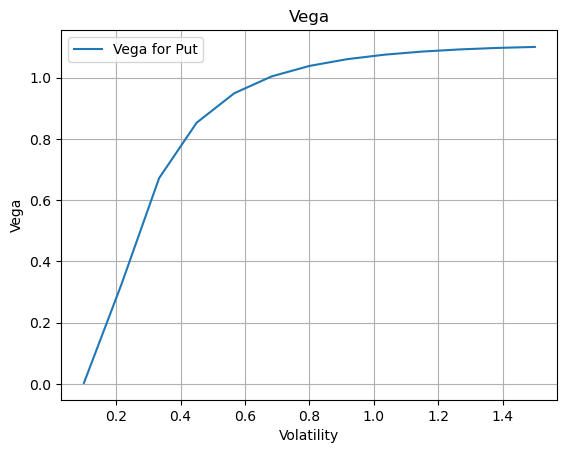

In [363]:
vol = np.linspace(0.1,1.5,13)
Vega = np.zeros((len(vol),1))
for i in range(len(vol)):
    Vega [i] = vega(S0, K, T, r, 0, vol[i], payoff)
    
fig = plt.figure()
plt.plot(vol, Vega, '-')
plt.grid()
plt.xlabel('Volatility')
plt.ylabel('Vega')
plt.title('Vega')
plt.legend(['Vega for Put'])

### Gamma

In [364]:
def gamma(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    gamma = np.exp(-r * T) * si.norm.pdf(d1, 0.0, 1.0) / (vol * S * np.sqrt(T))
    
    return gamma

In [365]:
gamma(S0, K, T, r, 0, sig, payoff)

0.09267417216313877

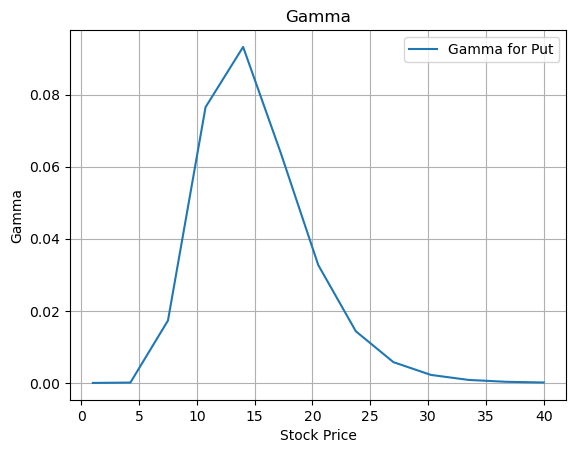

In [366]:
S = np.linspace(1,40,13)
Gamma = np.zeros((len(S),1))
for i in range(len(S)):
    Gamma [i] = gamma(S[i], K, T, r, 0, sig, payoff)
    
fig = plt.figure()
plt.plot(S, Gamma, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Gamma')
plt.title('Gamma')
plt.legend(['Gamma for Put'])

### Speed

In [367]:
def speed(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    speed = np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / ((vol **2) * (S**2) * np.sqrt(T)) * (d1 + vol * np.sqrt(T))
    
    return speed

In [368]:
speed(S0, K, T, r, 0, sig, payoff)

0.000994238720069702

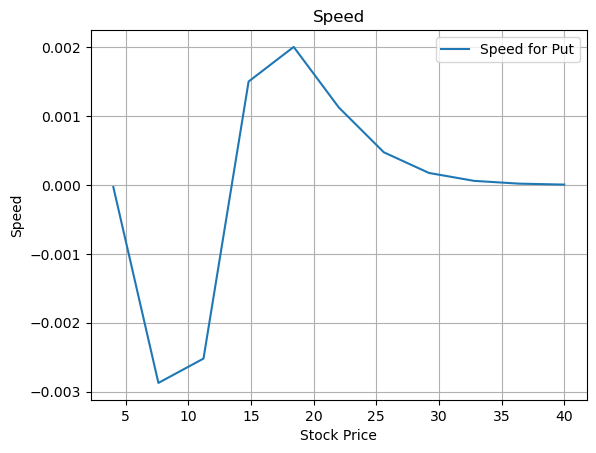

In [369]:
S = np.linspace(4,40,11)
Speed = np.zeros((len(S),1))
for i in range(len(S)):
    Speed [i] = speed(S[i], K, T, r, 0, sig, payoff)

fig = plt.figure()
plt.plot(S, Speed, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Speed')
plt.title('Speed')
plt.legend(['Speed for Put'])

### Theta

In [370]:
def theta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        theta = vol * S * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        theta = vol * S * np.exp(-q * T) * si.norm.pdf(-d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return theta

In [377]:
theta(S0, K, T, r, 0, sig, payoff)

22.484875582111666

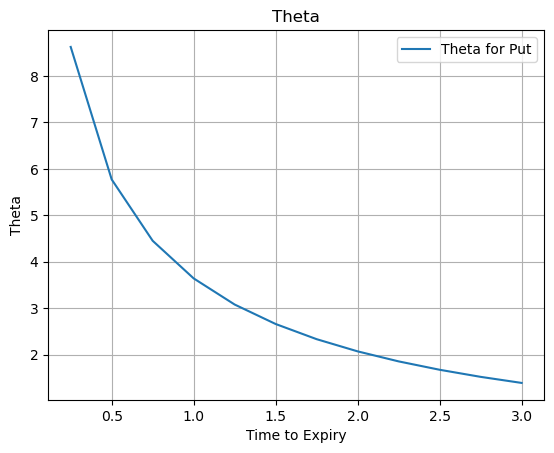

In [372]:
t = np.linspace(0.25,3,12)
Theta_Call = np.zeros((len(t),1))
Theta_Put = np.zeros((len(t),1))
for i in range(len(t)):
    Theta_Put [i] = theta(S0, K, t[i], r, 0, sig, payoff)
    
fig = plt.figure()
plt.plot(t, Theta_Put, '-')
plt.grid()
plt.xlabel('Time to Expiry')
plt.ylabel('Theta')
plt.title('Theta')
plt.legend(['Theta for Put'])

### Rho

In [373]:
def rho(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        rho =  K * T * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        rho = - K * T * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return rho

In [374]:
rho(S0, K, T, r, 0, sig, payoff)

-0.3748778322974213

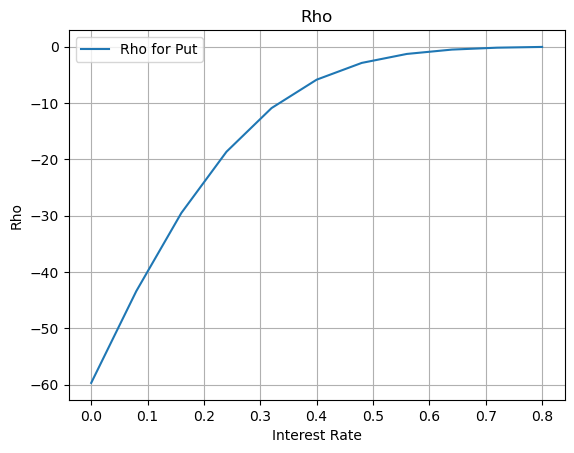

In [375]:
r_line = np.linspace(0,0.8,11)
Rho_Call = np.zeros((len(r_line),1))
Rho_Put = np.zeros((len(r_line),1))
for i in range(len(r_line)):
    Rho_Put [i] = rho(100, 100, 1, r_line[i], 0.03, 0.25, 'put')

fig = plt.figure()
plt.plot(r_line, Rho_Put, '-')
plt.grid()
plt.xlabel('Interest Rate')
plt.ylabel('Rho')
plt.title('Rho')
plt.legend(['Rho for Put'])